# 3D Data Processing

---
A.A. 2025 - Wanmeng Li, Daniel Fusaro
---


## Lab - PointNet: Point Cloud 3D Descriptors

original paper -
[PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://web.stanford.edu/~rqi/pointnet/)

dataset link: https://drive.google.com/drive/folders/1IweJGcOeOZN3wY79i2jFt3JE1bd7G51Z?usp=share_link

SHOT descriptions: [lecture](https://stem.elearning.unipd.it/pluginfile.php/1107614/mod_resource/content/1/Slide_3DP_13_3D%20Local%20Descriptors.pdf)

To add a link to the dataset in your Google Drive main folder, you need to:

 - Click on the link
 - Right click on "dataset"
 - Click Add shortcut to Drive

When you will mount your drive folder in Colab you will find this folder without the need of re-uploading it.

In [ ]:
import numpy as np
import random
import math
import time
import copy
import os
import glob

import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# pyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# a nice training progress bar
from tqdm import tqdm, trange

In [ ]:
running_on_colab = True

if running_on_colab:
    # useful for visualization
    ## note: it's not necessary to restart the notebook environment after installation
    !pip install open3d

    import plotly.graph_objects as go

# visualization
import open3d as o3d


# Connect and mount your Google Drive

In [ ]:
if running_on_colab:
    from google.colab import drive
    drive_path = '/content/drive'
    drive.mount(drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# General Parameters

In [ ]:
# originaly the path was: os.path.join(drive_path, "MyDrive", "3D_dp_dataset", "3dshapes", "train")
if running_on_colab:
    dataset_path_train = os.path.join(drive_path, "MyDrive", "3dshapes", "train")
    dataset_path_valid = os.path.join(drive_path, "MyDrive", "3dshapes", "valid")
    dataset_path_test = os.path.join(drive_path,  "MyDrive", "3dshapes", "test")
else:
    dataset_path_train = os.path.join("datasets", "train")
    dataset_path_valid = os.path.join("datasets", "valid")
    dataset_path_test = os.path.join("datasets", "test")

# Visualization Example
In order to visualize colored point clouds we make use of the Python package *Open3D*.

Unfortunately, the original doesn't run on Colab.
So, we replace the drawing function with a custom one (*draw_geometries*) that allows for rendering here on Colab.



In [ ]:
if running_on_colab:
    def draw_geometries(geometries):
        graph_objects = []

        for geometry in geometries:
            geometry_type = geometry.get_geometry_type()

            if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
                points = np.asarray(geometry.points)
                colors = None
                if geometry.has_colors():
                    colors = np.asarray(geometry.colors)
                elif geometry.has_normals():
                    colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
                else:
                    geometry.paint_uniform_color((1.0, 0.0, 0.0))
                    colors = np.asarray(geometry.colors)

                scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
                graph_objects.append(scatter_3d)

            if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
                triangles = np.asarray(geometry.triangles)
                vertices = np.asarray(geometry.vertices)
                colors = None
                if geometry.has_triangle_normals():
                    colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                    colors = tuple(map(tuple, colors))
                else:
                    colors = (1.0, 0.0, 0.0)

                mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
                graph_objects.append(mesh_3d)

        fig = go.Figure(
            data=graph_objects,
            layout=dict(
                scene=dict(
                    xaxis=dict(visible=False),
                    yaxis=dict(visible=False),
                    zaxis=dict(visible=False),
                    aspectmode='data'
                )
            )
        )
        fig.show()

In [ ]:
if running_on_colab:
    o3d.visualization.draw_geometries = draw_geometries

anchor_color   = [0, 0, 1.0] # blue
positive_color = [0, 1.0, 0] # green
negative_color = [1.0, 0, 0] # red
p_colors = [anchor_color, positive_color, negative_color]

def visualize( pointcloud:np.array =None,
               anchor    :np.array =None,
               positive  :np.array =None,
               negative  :np.array =None,
               radius    :np.array =None,
               rot_mat   :np.array =None):
    """
    INPUT
      pointcloud : numpy array of 3D points
      anchor     : anchor point
      positive   :
      negative   :
    """
    geoms = []
    if pointcloud is not None:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pointcloud)
        pcd.paint_uniform_color([0.6, 0.6, 0.6])
        if rot_mat is not None:
            pcd.rotate(rot_mat, center=(0, 0, 0))
        geoms.append(pcd)
    for point, color in zip([anchor, positive, negative], p_colors):
        if point is not None:
            assert radius is not None
            sphere = o3d.geometry.TriangleMesh.create_sphere(radius=radius, resolution=20)
            sphere.translate(point)
            sphere.paint_uniform_color(color)
            geoms.append(sphere)
    # visualize the colored point cloud
    #o3d.visualization.draw_geometries(geoms)

# PointCloud Dataset

`torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

* `__init__` to initialize your dataset. For example, if your dataset fits in memory, you can load the entire dataset in a list, or you can just store the list of dataset files.
* `__len__` so that len(dataset) returns the size of the dataset.
* `__getitem__` to support indexing such that `dataset[i]` can be used to get  the i-th sample

Therefore, the structure of the class is:

```
class CustomDataset(Dataset):

    def __init__(self, init_parameters):
        self.param1 = param1
        [...]

    def __len__(self):
        [...]

    def __getitem__(self, idx):
        [...]

        return sample[idx]
```


#Parameter Tuning
This cell was added to help with tuning the model parameters.



In [ ]:
LEARNING_RATE = 0.0005
RADIUS = 0.05
N_POINTS = 750
EPOCHS = 20

In [ ]:
class PointCloudData(Dataset):
    def __init__(self,
                dataset_path: str,
                samples_per_epoch: int,
                points_to_sample:int = 200000,
                radius:float = RADIUS,
                min_dist=1.5e-2,
                N = N_POINTS,
                noise_mean=0,
                noise_variance = 6e-5,
                is_test_set=False):
        """
          INPUT
              dataset_path: path to the dataset folder
              transform   : transform function to apply to point cloud
        """

        self.radius = radius
        self.min_dist = min_dist
        self.N = N
        self.samples_per_epoch = samples_per_epoch
        self.points_to_sample = points_to_sample
        self.noise_mean = noise_mean
        self.noise_variance = noise_variance
        self.is_test_set = is_test_set

        # _n means noised version
        self.mesh = []
        self.pcds, self.pcds_n = [], []
        self.KDtrees, self.KDtrees_n = [], []

        ## if it's the test set, pre-define a random rotation matrix
        if self.is_test_set:
            self.common_rot_mat = self.get_xyz_random_rotation()

        for file in glob.glob(dataset_path + "/*.ply"):
            print("parsing file", file)
            mesh = o3d.io.read_triangle_mesh(file)
            pcd = mesh.sample_points_uniformly(self.points_to_sample)
            if self.is_test_set:
                pcd.rotate(self.common_rot_mat.as_matrix(), center=(0, 0, 0))
            pcd_tree = o3d.geometry.KDTreeFlann(pcd)

            pcd_n = self.apply_noise(mesh.sample_points_uniformly(self.points_to_sample), self.noise_mean, self.noise_variance)
            if self.is_test_set:
                pcd_n.rotate(self.common_rot_mat.as_matrix(), center=(0, 0, 0))
            pcd_n_tree = o3d.geometry.KDTreeFlann(pcd_n)

            self.mesh.append(mesh)

            self.pcds.append(np.asarray(pcd.points))
            self.pcds_n.append(np.asarray(pcd_n.points))

            self.KDtrees.append(pcd_tree)
            self.KDtrees_n.append(pcd_n_tree)

    # function to apply noise
    def apply_noise(self, pcd, mu, sigma):
        noisy_pcd = copy.deepcopy(pcd)
        points = np.asarray(noisy_pcd.points)
        points += np.random.normal(mu, sigma, size=points.shape)
        noisy_pcd.points = o3d.utility.Vector3dVector(points)
        return noisy_pcd

    def __len__(self):
        return self.samples_per_epoch

    def get_xyz_random_rotation(self):
        random_rotation_on_xyz_axis = np.random.rand(3) * 2 * np.pi
        return R.from_euler('xyz', random_rotation_on_xyz_axis, degrees=False)

    def get_point_cloud_center(self, pc_points):
        return pc_points.mean(axis=0)

    def apply_rotation(self, point, rot_mat, pcd_center):
        return np.dot(point.reshape(1, 3), rot_mat.as_matrix().T)[0, :]

    def apply_rotation_pc(self, points, rot_mat, pcd_center):
        return np.dot(points, rot_mat.as_matrix().T)

    def bufferize_pointcloud(self, points, N):
        pc = np.zeros((self.N, 3), dtype=np.float32)
        pc[:min(self.N, points.shape[0]), :] = points[:min(self.N, points.shape[0]), :]
        return pc

    def sample_anchor_point(self, pcd_points, pcd_tree):
        ############# START ###########

        anchor_idx = np.random.randint(0, pcd_points.shape[0]) #random point
        anchor_pt = pcd_points[anchor_idx]
        _, anchor_neighborhood_idxs, _ = pcd_tree.search_radius_vector_3d(anchor_pt, self.radius) # neighborhood points within radius

        # fall-back: ensure we have enough points in the neighborhood
        if len(anchor_neighborhood_idxs) < 10:
            return self.sample_anchor_point(pcd_points, pcd_tree)

        ############# END #############
        return anchor_pt, anchor_neighborhood_idxs

    def sample_positive_point(self, pcd_n_points, pcd_n_tree, anchor_pt):
        _, noisy_anchor_nn_idx, _ = pcd_n_tree.search_knn_vector_3d(anchor_pt, 1)

        ############# START ###########

        pos_pt = pcd_n_points[noisy_anchor_nn_idx[0]] # closest point

        _, noisy_positive_neighborhood_idxs, _ = pcd_n_tree.search_radius_vector_3d(pos_pt, self.radius) # find neighborhood

        # fall-back: ensure we have enough points in the neighborhood
        min_points = 10
        if len(noisy_positive_neighborhood_idxs) < min_points:
            # try expanding search radius
            _, noisy_positive_neighborhood_idxs, _ = pcd_n_tree.search_radius_vector_3d(pos_pt, self.radius * 1.5)

        ############# END #############

        return pos_pt, noisy_positive_neighborhood_idxs

    def sample_negative_point(self, pcd_n_points, pcd_n_tree, anchor_pt):
        ############# START ###########
        max_attempts = 100
        min_points = 10

        for attempt in range(max_attempts):

            neg_idx = np.random.randint(0, pcd_n_points.shape[0]) # random point
            neg_pt = pcd_n_points[neg_idx]

            # check if the distance is greater than min_dist
            dist = np.linalg.norm(anchor_pt - neg_pt)
            if dist >= self.min_dist:
                _, noisy_negative_neighborhood_idxs, _ = pcd_n_tree.search_radius_vector_3d(neg_pt, self.radius) # find neighborhood

                # ensure we have enough points in the neighborhood
                if len(noisy_negative_neighborhood_idxs) >= min_points:
                    return neg_pt, noisy_negative_neighborhood_idxs
                else:
                    # try expanding radius
                    _, noisy_negative_neighborhood_idxs, _ = pcd_n_tree.search_radius_vector_3d(neg_pt, self.radius * 1.5)
                    if len(noisy_negative_neighborhood_idxs) >= min_points:
                        return neg_pt, noisy_negative_neighborhood_idxs

        return None, None

        ############# END #############

    def get_sampled_pointcloud(self, mesh_idx, N):
        idxs = np.arange(0, self.pcds[mesh_idx].shape[0], 1)
        np.random.shuffle(idxs)
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(self.pcds[mesh_idx][idxs[:N]])
        return pcd

    def generate_test_set(self, mesh_idx, N=500):

        self.test_points = self.pcds[mesh_idx]

        ## sample test points randomly
        idxs = np.arange(0, self.test_points.shape[0], 1)
        np.random.shuffle(idxs)
        self.test_points_sampled = self.test_points[idxs[:N]]

        # ## as a bonus study: you can sample keypoints from the point cloud
        # ## using open3d and analyze the results. Keypoints are inherently easier.
        # pcd = o3d.geometry.PointCloud()
        # pcd.points = o3d.utility.Vector3dVector(self.pcds[mesh_idx])
        # keypoints = o3d.geometry.keypoint.compute_iss_keypoints(pcd,
        #                                                 salient_radius=0.005,
        #                                                 non_max_radius=0.005,
        #                                                 gamma_21=0.4,
        #                                                 gamma_32=0.5)
        # self.test_points_sampled = np.random.permutation(np.asarray(keypoints.points))

        self.test_tree = self.KDtrees[mesh_idx]

    def generate_noisy_test_set(self, mesh_idx):
        self.test_points_n = self.pcds_n[mesh_idx]
        self.test_tree_n = self.KDtrees_n[mesh_idx]

        test_points_sampled_n = []
        for i in tqdm(range(self.test_points_sampled.shape[0])):
            _, gt_nn_idx, _ = self.test_tree_n.search_knn_vector_3d(self.test_points_sampled[i], 1)
            gt_nearest_point = self.test_points_n[gt_nn_idx].squeeze()
            test_points_sampled_n.append(gt_nearest_point)

        self.test_points_sampled_n = np.asarray(test_points_sampled_n)

    def compute_descriptors(self, tinypointnet, noisy=False):
        tinypointnet.eval()

        if noisy:
            queries = self.test_points_sampled_n
            tree    = self.test_tree_n
            points  = self.test_points_n
        else:
            queries = self.test_points_sampled
            tree    = self.test_tree
            points  = self.test_points
        tot_queries = queries.shape[0]

        descriptors = np.zeros((tot_queries, 256), dtype=np.float32)
        for i in tqdm(range(tot_queries)):
            pt = queries[i]

            ## find neighborhood of points
            _, idx, _ = tree.search_radius_vector_3d(pt, self.radius)
            point_set = points[idx]

            ## normalize the points
            point_set = (point_set - pt)

            pc = np.zeros((self.N, 3), dtype=np.float32)
            pc[:min(self.N, point_set.shape[0]), :] = point_set[:min(self.N, point_set.shape[0]), :]

            # transform
            anchor  = torch.from_numpy(pc).unsqueeze(0).float().transpose(1,2).to(device)
            descriptors[i, :] = tinypointnet(anchor)[0, :, 0].cpu().detach().numpy()
        return descriptors

    def __getitem__(self, _):
        mesh_idx = np.random.randint(0, len(self.mesh))

        pcd_points = self.pcds[mesh_idx]        ## anchor will be drawn from this
        pcd_n_points = self.pcds_n[mesh_idx]    ## positive and negative will be drawn from this

        # ANCHOR: select a random anchor point
        anchor_pt, anchor_neighborhood_idxs = self.sample_anchor_point(pcd_points, self.KDtrees[mesh_idx])

        # POSITIVE: find corresponding point in the noisy point cloud
        pos_pt, noisy_positive_neighborhood_idxs = self.sample_positive_point(pcd_n_points, self.KDtrees_n[mesh_idx], anchor_pt)

        # NEGATIVE: find far point (at least at distance min_dist)
        neg_pt, noisy_negative_neighborhood_idxs = self.sample_negative_point(pcd_n_points, self.KDtrees_n[mesh_idx], anchor_pt)
        if neg_pt is None: ## it should never fail, but if it fails: restart experiment
            quit("FAIL: restart experiment")


        # get points
        point_set_anchor   = pcd_points[anchor_neighborhood_idxs]
        point_set_positive = pcd_n_points[noisy_positive_neighborhood_idxs]
        point_set_negative = pcd_n_points[noisy_negative_neighborhood_idxs]

        if not self.is_test_set:
            # generate a random rotation
            rot_mat = self.get_xyz_random_rotation()

            # apply the random rotation to point cloud and points
            pcd_points_center = self.get_point_cloud_center(pcd_points)
            pcd_n_points_center = self.get_point_cloud_center(pcd_n_points)
            anchor_pt = self.apply_rotation(anchor_pt, rot_mat, pcd_points_center)
            pos_pt    = self.apply_rotation(pos_pt, rot_mat, pcd_n_points_center)
            neg_pt    = self.apply_rotation(neg_pt, rot_mat, pcd_n_points_center)
            point_set_anchor   = self.apply_rotation_pc(point_set_anchor, rot_mat, pcd_points_center)
            point_set_positive = self.apply_rotation_pc(point_set_positive, rot_mat, pcd_n_points_center)
            point_set_negative = self.apply_rotation_pc(point_set_negative, rot_mat, pcd_n_points_center)
        else:
            rot_mat = self.common_rot_mat

        # center points around their centroid
        point_set_anchor   = (point_set_anchor - anchor_pt)
        point_set_positive = (point_set_positive - pos_pt)
        point_set_negative = (point_set_negative - neg_pt)

        # copy points coordinates to a fixed dimension np.array
        point_set_anchor   = self.bufferize_pointcloud(point_set_anchor  , self.N)
        point_set_positive = self.bufferize_pointcloud(point_set_positive, self.N)
        point_set_negative = self.bufferize_pointcloud(point_set_negative, self.N)

        # transform from numpy to torch.Tensor
        point_set_anchor    = torch.from_numpy(point_set_anchor)
        point_set_positive  = torch.from_numpy(point_set_positive)
        point_set_negative  = torch.from_numpy(point_set_negative)

        return mesh_idx, point_set_anchor, point_set_positive, point_set_negative, anchor_pt, pos_pt, neg_pt, rot_mat.as_matrix()


# Dataset Creation

Now we can instantiate our training and test dataset objects.

In [ ]:
train_ds  = PointCloudData(dataset_path_train, samples_per_epoch=500)
valid_ds  = PointCloudData(dataset_path_valid, samples_per_epoch=500)
test_ds   = PointCloudData(dataset_path_test,  samples_per_epoch=500, is_test_set=True)

parsing file /content/drive/MyDrive/3dshapes/train/bun_zipper.ply
parsing file /content/drive/MyDrive/3dshapes/train/dragon_vrip.ply
parsing file /content/drive/MyDrive/3dshapes/train/Armadillo.ply
parsing file /content/drive/MyDrive/3dshapes/valid/bun_zipper.ply
parsing file /content/drive/MyDrive/3dshapes/valid/dragon_vrip.ply
parsing file /content/drive/MyDrive/3dshapes/valid/Armadillo.ply
parsing file /content/drive/MyDrive/3dshapes/test/happy_vrip.ply


Creating a `Dataset` class may seem unnecessary for the most basic problems. But it really helps when the dataset and the training procedure start to get more complex.

One of the most useful benefit of defining a `Dataset` class is the possiblity to use the PyTorch `Dataloader` module.

By operating on the dataset directly, we are losing out on a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.

`torch.utils.data.DataLoader` is an iterator which provides all these features. Parameters used below should be clear.

In [ ]:
# warning: batch_size needs to be at least 2
train_loader  = DataLoader( dataset=train_ds,  batch_size=50, shuffle=True  )
valid_loader  = DataLoader( dataset=valid_ds,  batch_size=50, shuffle=False )
test_loader   = DataLoader( dataset=test_ds,   batch_size=20, shuffle=False )

# Visualize some data

In [ ]:
ds = train_ds

for (mesh_idx, _, _, _, anchor, positive, negative, rot_mat) in ds:
    idx = mesh_idx
    visualize(ds.pcds[idx],
              anchor = anchor,
              positive = positive,
              negative = negative,
              radius=ds.radius,
              rot_mat=rot_mat)
    break


# Network Definition

## Network Base Module

A network is defined by extending the *torch.nn.module* class. The basic structure is:

```
class Net(nn.Module):
    
    def __init__(self, input_parameters):
        super().__init__() # This executes the parent __init__ method
        [...]

    def forward(self, x, optional_parameters):
        [...]
        return out # return the output of the network
```

You need to define two methods:
*   **\_\_init\_\_**: The constructor method. This is exectuted when the object is initialized (no need to call it explicitly). Here you have to instantiate all the network's parameters. PyTorch provides utility functions to easily initialize most of the commonly used deep learning layers.
*   **forward**: Here you define the forward pass of the network, from the input *x* to the output (the method must return the network output). You just need to define the forward part, the back-propagation is automatically tracked by the framework!

In [ ]:
# Multi Layer Perceptron
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size   = input_size
        self.output_size  = output_size
        self.conv  = nn.Conv1d(self.input_size, self.output_size, 1)
        self.bn    = nn.BatchNorm1d(self.output_size)

    def forward(self, input):
        return F.relu(self.bn(self.conv(input)))

# Fully Connected with Batch Normalization
class FC_BN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size   = input_size
        self.output_size  = output_size
        self.lin  = nn.Linear(self.input_size, self.output_size)
        self.bn    = nn.BatchNorm1d(self.output_size)

    def forward(self, input):
        return F.relu(self.bn(self.lin(input)))

class TNet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k

        self.mlp1 = MLP(self.k, 64)
        self.mlp2 = MLP(64, 128)
        self.mlp3 = MLP(128, 1024)

        self.fc_bn1 = FC_BN(1024, 512)
        self.fc_bn2 = FC_BN(512,256)

        self.fc3 = nn.Linear(256,k*k)


    def forward(self, input):
        # input.shape == (batch_size,n,3)

        bs = input.size(0)
        xb = self.mlp1(input)
        xb = self.mlp2(xb)
        xb = self.mlp3(xb)

        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)

        xb = self.fc_bn1(flat)
        xb = self.fc_bn2(xb)

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix

In [ ]:
class TinyPointNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform   = TNet(k=3) ## if you use the shot rotation matrix, this is not going to be used
        self.feature_transform = TNet(k=64)

        ############# START ###########
        self.mlp1 = MLP(3, 64)
        self.mlp2 = MLP(64, 64)

        self.mlp3 = MLP(64, 64)
        self.mlp4 = MLP(64, 128)
        self.mlp5 = MLP(128, 256)

        ############# END #############

    def forward(self, input):
        n_pts = input.size()[2]
        matrix3x3 = self.input_transform(input)                               #CHANGE ROTATION MATRIX HERE-------------------------------------------------
        #matrix3x3 = self.shot_canonical_rotation(input, 3)

        input_transform_output = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        ############# START ###########
        x = self.mlp1(input_transform_output)
        x = self.mlp2(x)

        # feature transformation
        matrix64x64 = self.feature_transform(x)
        feature_transform_output = torch.bmm(torch.transpose(x,1,2), matrix64x64).transpose(1,2)

        x = self.mlp3(feature_transform_output)
        x = self.mlp4(x)
        x = self.mlp5(x)

        # global max pooling
        global_feature = nn.MaxPool1d(x.size(-1))(x)

        ############# END #############

        return global_feature


    def shot_canonical_rotation(self, input, k):
        # input.shape == (batch_size, n, k)
        batch_size, n, _ = input.size()
        rotation_matrices = []
        for i in range(batch_size):
            features_batch = input[i]
            centroid = torch.mean(features_batch, dim=1, keepdim=True)
            centered_features = features_batch - centroid
            if torch.any(torch.isnan(centered_features)) or torch.any(torch.isinf(centered_features)):
                centered_features[torch.isnan(centered_features) | torch.isinf(centered_features)] = 1e-6
            distances = torch.norm(centered_features, dim=0)

            # Fix the weights calculation to match your working version
            max_distance = torch.max(distances) + 1e-6
            weights = 1.0 - distances / max_distance
            weights[weights < 0] = 0
            weights_sum = torch.sum(weights)
            if weights_sum > 0:
                weights = weights / weights_sum
            else:
                weights = torch.ones_like(weights) / n
            weighted_cov_matrix = torch.zeros((centered_features.size(0), centered_features.size(0)), device=input.device)

            ############# START ###########
            ### compute the covariance matrix
            weighted_features = centered_features * weights.unsqueeze(0)
            weighted_cov_matrix = torch.matmul(weighted_features, centered_features.transpose(0, 1))
            ############# END #############

            weighted_cov_matrix += torch.eye(weighted_cov_matrix.size(-1), device=input.device) * 1e-6

            ############# START ###########
            ### compute the eigenvectors of covariance matrix
            eigenvalues, eigenvectors = torch.linalg.eigh(weighted_cov_matrix)
            # sort eigenvalues in descending order and get corresponding eigenvectors
            idx = torch.argsort(eigenvalues, descending=True)
            V = eigenvectors[:, idx]
            ############# END #############

            rotation_matrix = V[:, :k]
            for j in range(k):
                signs = torch.sign(torch.sum(centered_features * rotation_matrix[:, j].unsqueeze(1), dim=0))
                if torch.sum(signs >= 0) < torch.sum(signs < 0):
                    rotation_matrix[:, j] = -rotation_matrix[:, j]
            rotation_matrices.append(rotation_matrix)
        return torch.stack(rotation_matrices, dim=0)

# Training loop

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
tinypointnet = TinyPointNet()
tinypointnet.to(device)

TinyPointNet(
  (input_transform): TNet(
    (mlp1): MLP(
      (conv): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp2): MLP(
      (conv): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp3): MLP(
      (conv): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fc_bn1): FC_BN(
      (lin): Linear(in_features=1024, out_features=512, bias=True)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fc_bn2): FC_BN(
      (lin): Linear(in_features=512, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fc3): Linear(in_features=256, out_features=9, bias

In [ ]:
optimizer = torch.optim.Adam(tinypointnet.parameters(), lr=LEARNING_RATE)

In [ ]:
def soft_triplet_loss(anchor, positive, negative, alpha=1.0):
    ############## START #############

    # flatten descriptors to ensure proper shape
    anchor = anchor.view(anchor.size(0), -1)
    positive = positive.view(positive.size(0), -1)
    negative = negative.view(negative.size(0), -1)

    # L2 distances
    pos_dist = torch.norm(anchor - positive, p=2, dim=1)
    neg_dist = torch.norm(anchor - negative, p=2, dim=1)

    # soft triplet loss
    loss = torch.log(1 + torch.exp(alpha * (pos_dist - neg_dist)))
    ############## END ###############

    return loss.mean()

def standard_triplet_loss(anchor, positive, negative, alpha=0.1):

    # flatten descriptors to ensure proper shape
    anchor = anchor.view(anchor.size(0), -1)
    positive = positive.view(positive.size(0), -1)
    negative = negative.view(negative.size(0), -1)

    # L2 distances
    pos_dist = torch.norm(anchor - positive, p=2, dim=1)
    neg_dist = torch.norm(anchor - negative, p=2, dim=1)

    # standard triplet loss
    loss = torch.relu(pos_dist - neg_dist + alpha)  # relu(x) = max(x,0)

    return loss.mean()

def contrastive_loss(anchor, positive, negative, margin=1.0):

    # flatten descriptors to ensure proper shape
    anchor = anchor.view(anchor.size(0), -1)
    positive = positive.view(positive.size(0), -1)
    negative = negative.view(negative.size(0), -1)

    # compute distances
    pos_dist = torch.norm(anchor - positive, p=2, dim=1)
    neg_dist = torch.norm(anchor - negative, p=2, dim=1)

    # contrastive loss
    pos_loss = pos_dist.pow(2)
    neg_loss = F.relu(margin - neg_dist).pow(2)

    loss = pos_loss + neg_loss
    return loss.mean()

def train(model, train_loader, valid_loader=None,  epochs=EPOCHS, save=True):
    best_valid_loss = 1e10
    ############## START #############
    ####### COMPLETE THIS PART: put the correct loss function #######   #-----------------------------------CHANGE LOSS HERE------------------------------------

    # For standard triplet loss:
    tinypointnetloss = standard_triplet_loss

    # For soft triplet loss:
    #tinypointnetloss = soft_triplet_loss

    # For contrastive_loss loss:
    #tinypointnetloss = contrastive_loss

    ############## END ###############

    # these lists keep track of the losses across epochs
    train_losses, valid_losses = [], []

    total_start_time = time.time() # start timing

    for epoch in range(epochs):
        start_time = time.time()
        # local list of losses
        train_loss, valid_loss = [], []

        # train
        tinypointnet.train()

        for (_, anchor, positive, negative, _, _, _, _) in tqdm(train_loader):

            # retrieve anchors, positives and negatives batch
            anchor   =   anchor.to(device).float().transpose(1,2)
            positive = positive.to(device).float().transpose(1,2)
            negative = negative.to(device).float().transpose(1,2)

            optimizer.zero_grad()

            # let PointNetTiny model compute the descriptors
            anchor_desc   = tinypointnet(anchor)
            positive_desc = tinypointnet(positive)
            negative_desc = tinypointnet(negative)

            # compute the loss associated to these descriptors
            loss = tinypointnetloss(anchor_desc, positive_desc, negative_desc)


            # Backpropagate the gradient
            loss.backward()
            optimizer.step()

            # Keep track of the statistics
            train_loss.append(loss.item())
            #pbar.set_postfix(loss=curr_loss)

        train_loss = np.asarray(train_loss).mean()
        print(f'epoch {epoch} - train loss: {train_loss:.6f}')
        train_losses.append(train_loss)

        # validation
        start_time = time.time()
        tinypointnet.eval()
        pbar = tqdm(valid_loader, leave=False)

        with torch.no_grad():
            for (_, anchor, positive, negative, _, _, _, _) in pbar:
                pbar.set_description(f"valid - epoch {epoch}")

                anchor   =   anchor.to(device).float().transpose(1,2)
                positive = positive.to(device).float().transpose(1,2)
                negative = negative.to(device).float().transpose(1,2)

                anchor_desc   = tinypointnet(anchor)
                positive_desc = tinypointnet(positive)
                negative_desc = tinypointnet(negative)
                loss = tinypointnetloss(anchor_desc, positive_desc, negative_desc)
                curr_loss = loss.item()

                valid_loss.append(curr_loss)

                pbar.set_postfix(loss=curr_loss)

        valid_loss = np.asarray(valid_loss).mean()
        print(f'epoch {epoch} - valid loss: {valid_loss:.6f}')
        valid_losses.append(valid_loss)

        # save the model
        if save and valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            if running_on_colab:
                path = os.path.join(drive_path, "MyDrive", "tinypointnetmodel.yml")
            else:
                path = os.path.join("tinypointnetmodel.yml")
            print("best_valid_loss:", best_valid_loss, "saving model at", path)
            torch.save(tinypointnet.state_dict(), path)

    total_end_time = time.time() # end timing
    print(f'\nTotal training time: {total_end_time - total_start_time:.2f}s')

    return train_losses, valid_losses

In [ ]:
train_losses, valid_losses = train(tinypointnet, train_loader, valid_loader, save=True)

100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


epoch 0 - train loss: 0.023143


epoch 0 - valid loss: 0.005528
best_valid_loss: 0.005528010032139719 saving model at /content/drive/MyDrive/tinypointnetmodel.yml


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch 1 - train loss: 0.004339


epoch 1 - valid loss: 0.000028
best_valid_loss: 2.7934982790611683e-05 saving model at /content/drive/MyDrive/tinypointnetmodel.yml


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


epoch 2 - train loss: 0.083082


epoch 2 - valid loss: 0.000000
best_valid_loss: 0.0 saving model at /content/drive/MyDrive/tinypointnetmodel.yml


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch 3 - train loss: 0.026367


epoch 3 - valid loss: 0.098601


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


epoch 4 - train loss: 0.010286


epoch 4 - valid loss: 0.012994


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


epoch 5 - train loss: 0.046330


epoch 5 - valid loss: 0.027584


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


epoch 6 - train loss: 0.022305


epoch 6 - valid loss: 0.108129


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


epoch 7 - train loss: 0.069497


epoch 7 - valid loss: 0.009619


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


epoch 8 - train loss: 0.024073


epoch 8 - valid loss: 0.008440


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


epoch 9 - train loss: 0.004313


epoch 9 - valid loss: 0.031762


100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


epoch 10 - train loss: 0.010394


epoch 10 - valid loss: 0.005661


100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


epoch 11 - train loss: 0.008760


epoch 11 - valid loss: 0.004524


100%|██████████| 10/10 [00:19<00:00,  1.90s/it]


epoch 12 - train loss: 0.005053


epoch 12 - valid loss: 0.005098


100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


epoch 13 - train loss: 0.004385


epoch 13 - valid loss: 0.001128


100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


epoch 14 - train loss: 0.044224


epoch 14 - valid loss: 0.009178


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


epoch 15 - train loss: 0.013483


epoch 15 - valid loss: 0.005565


100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


epoch 16 - train loss: 0.004103


epoch 16 - valid loss: 0.004609


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


epoch 17 - train loss: 0.002677


epoch 17 - valid loss: 0.007688


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


epoch 18 - train loss: 0.000773


epoch 18 - valid loss: 0.001016


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


epoch 19 - train loss: 0.017427


epoch 19 - valid loss: 0.003377

Total training time: 648.45s


## Visualize the Training trend

In [ ]:
def numpy_ewma_vectorized_v2(data, window=10):
    # Return the Exponentially Weighted Moving Average
    # for better visualizing the "trend" of the metrics

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

### Plot the trend of train and valid losses
By using an Exponentially Weighted Moving Average of the losses,
we can better understand the behaviour of our network by filtering out
the noisy *local values* and focusing more on the *global trend*.

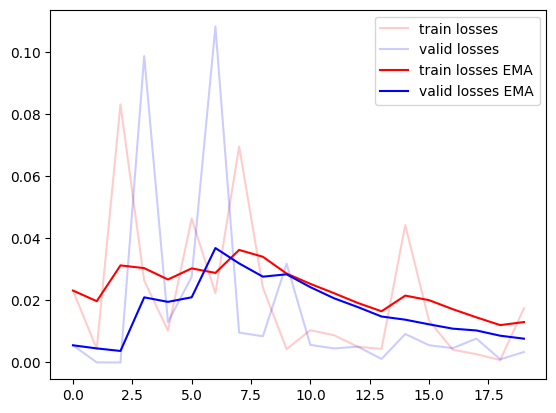

In [ ]:
plt.plot(train_losses, label="train losses", color='r', alpha=0.2)
plt.plot(valid_losses, label="valid losses", color='b', alpha=0.2)
plt.plot(numpy_ewma_vectorized_v2(np.array(train_losses)), label="train losses EMA", color='r')
plt.plot(numpy_ewma_vectorized_v2(np.array(valid_losses)), label="valid losses EMA", color='b')
plt.legend()

# Test: feature matching

Let's compute the model test metrics

> First we need to load the best model weights





## Load checkpoint

In [ ]:
if running_on_colab:
    path = os.path.join(drive_path, "MyDrive", "tinypointnetmodel.yml")
else:
    path = os.path.join("tinypointnetmodel.yml")
tinypointnet = TinyPointNet()
tinypointnet.load_state_dict(torch.load(path))
tinypointnet.to(device)

TinyPointNet(
  (input_transform): TNet(
    (mlp1): MLP(
      (conv): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp2): MLP(
      (conv): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp3): MLP(
      (conv): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fc_bn1): FC_BN(
      (lin): Linear(in_features=1024, out_features=512, bias=True)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fc_bn2): FC_BN(
      (lin): Linear(in_features=512, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fc3): Linear(in_features=256, out_features=9, bias

## Prepare the test set

In [ ]:
test_ds.generate_test_set(0, 2000)

## build the ground truth nearest neighbors
## in other words, find thepoints in the noisy test points
## that are the nearest neighbors to the original, sampled, test points
test_ds.generate_noisy_test_set(0)


100%|██████████| 2000/2000 [00:00<00:00, 67248.74it/s]


This cell was added as an attempt to visualize the colors in colab - code was taken from an LLM and left as it is

In [ ]:
import numpy as np
import plotly.graph_objects as go
import open3d as o3d
from tqdm import tqdm

def visualize_geometries(geometries):
    graph_objects = []

    for geom in geometries:
        if isinstance(geom, o3d.geometry.PointCloud):
            # Handle point cloud
            points = np.asarray(geom.points)

            if geom.has_colors():
                colors = np.asarray(geom.colors)
                if colors.max() > 1.0:
                    colors = colors / 255.0  # Normalize if needed
                colors = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for r, g, b in colors]
            else:
                colors = 'rgb(128, 128, 128)'  # Default gray

            graph_objects.append(go.Scatter3d(
                x=points[:, 0], y=points[:, 1], z=points[:, 2],
                mode='markers',
                marker=dict(size=2, color=colors)
            ))

        elif isinstance(geom, o3d.geometry.TriangleMesh):
            # Handle spheres (or other meshes)
            vertices = np.asarray(geom.vertices)
            triangles = np.asarray(geom.triangles)

            # Get color
            if geom.has_vertex_colors():
                vertex_colors = np.asarray(geom.vertex_colors)
                if vertex_colors.max() > 1.0:
                    vertex_colors = vertex_colors / 255.0
                color = vertex_colors.mean(axis=0)  # Average color
            else:
                color = [1.0, 0.0, 0.0]  # Default red

            graph_objects.append(go.Mesh3d(
                x=vertices[:, 0], y=vertices[:, 1], z=vertices[:, 2],
                i=triangles[:, 0], j=triangles[:, 1], k=triangles[:, 2],
                color=f'rgb({int(color[0]*255)},{int(color[1]*255)},{int(color[2]*255)})',
                opacity=0.8
            ))

    # Configure layout
    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode='data'
            ),
            margin=dict(l=0, r=0, b=0, t=0)
        )
    )
    fig.update_layout(height=800, showlegend=False)
    fig.show()

### Visualize the sampled test points
Little red spheres represent the test points sampled from the original test mesh

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(test_ds.test_points_sampled_n)
pcd.paint_uniform_color([0.5, 0.5, 0.5])
geoms = [pcd]

# visualize the colored point cloud
o3d.visualization.draw_geometries(geoms)

In [ ]:
pcd = test_ds.get_sampled_pointcloud(mesh_idx=0, N=5000)
pcd.paint_uniform_color([0.5, 0.5, 0.5])
geoms = [pcd]
for point in test_ds.test_points_sampled_n:
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1e-3)
    sphere.translate(point)
    sphere.paint_uniform_color([1, 0, 0])
    geoms.append(sphere)

# visualize the colored point cloud
o3d.visualization.draw_geometries(geoms)
#visualize_geometries(geoms) # to visualize colors

### Compute the descriptor of each point in each point set

In [ ]:
descs   = test_ds.compute_descriptors(tinypointnet)
descs_n = test_ds.compute_descriptors(tinypointnet, noisy=True)

100%|██████████| 2000/2000 [00:26<00:00, 76.65it/s]


## matching time!
In other words, get the descriptor from the noisy point cloud which is closest to the query descriptor from the original point cloud

In [ ]:
pcd = test_ds.get_sampled_pointcloud(mesh_idx=0, N=5000)
pcd.paint_uniform_color([0.5, 0.5, 0.5])
geoms = [pcd]
for row in tqdm(range(test_ds.test_points_sampled_n.shape[0])):
    anchor       = test_ds.test_points_sampled[row]
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1e-3)
    sphere.translate(anchor)
    sphere.paint_uniform_color([1, 0, 0])
    geoms.append(sphere)


o3d.visualization.draw_geometries(geoms)
#visualize_geometries(geoms) # to visualize colors

100%|██████████| 2000/2000 [00:00<00:00, 21712.51it/s]


In [ ]:
correct = tot = 0

for row in tqdm(range(test_ds.test_points_sampled.shape[0])):
    desc = descs[row, :]
    dists = []
    anchor       = test_ds.test_points_sampled[row]
    true_near_pt = test_ds.test_points_sampled_n[row]

    for row2 in range(test_ds.test_points_sampled_n.shape[0]):
        desc2 = descs_n[row2, :]
        dist = np.linalg.norm(desc - desc2)
        dists.append(dist)

    min_row = np.argmin(np.asarray(dists))

    pred_pt = test_ds.test_points_sampled_n[min_row].squeeze()

    dist = np.linalg.norm(true_near_pt - pred_pt)

    # visualize(test_ds.test_points_sampled,
    #           anchor = anchor,
    #           positive = pred_pt,
    #           radius=test_ds.radius)

    if dist<test_ds.radius:
        correct += 1
    tot += 1

print()
print(f"accuracy: {correct*100/tot:6.3f}%")



100%|██████████| 2000/2000 [00:22<00:00, 90.73it/s] 


accuracy: 97.850%
